<h1 style="font-family:Times New Roman; font-size: 300%"><center>Machine Learning For Physics;Project 3 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Ideal pendulum Analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    The following notebook is my first on the Hamiltonian neural networks and ideal pendulum. For simplicity, m and l is set to 1, and g is set to 3 in the Hamiltonian
</p>

In [75]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
Pkg.add("Revise"); using Revise
using Lux, Optimisers, Plots, Statistics, Random, LinearAlgebra, Zygote,Distributions,NBInclude
Pkg.add("MLUtils"); using MLUtils

includet("Data.jl") #This generates data
includet("NeuralNetwork.jl") #Everything relevant for training the neural network is here

┌ Warning: skipping callee Main.:(var"#RK4_step#40") (called by Main.RK4_step) due to AssertionError("isexpr(bodystmt, :call)")
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/h7PQC/src/signatures.jl:328
  Activating project at `~/~/.julia/environments/v1.11.1`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`


In [77]:
fieldd = meshgrid(20, train=false)
spring_field = grads_ideal_pend(fieldd).*0.1 #Mainly for plotting purposes

#We generate training and testing data. Training data has 25 unique simulations, each with 30 datapoints.
t, x_train,y_train = generate_data(grads_ideal_pend, 25, 30, 4*pi, sigma=0.01, sampler=sample_pend, min_e=1.3, max_e=2.3) |>f32
_, x_test, y_test = generate_data(grads_ideal_pend, 1, 30, 4*pi, sigma=0.01, sampler=sample_pend, min_e=1.3, max_e=2.3) |>f32

x_Train = reshape(x_train, 2, 30*25) #Reshape 2x30x25 -> 2x750
y_Train = reshape(y_train, 2, 30*25)

train_data = DataLoader((x_Train,y_Train),batchsize=30) #Put inside a Dataloader

25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=30)
  with first element:
  (2×30 Matrix{Float32}, 2×30 Matrix{Float32},)

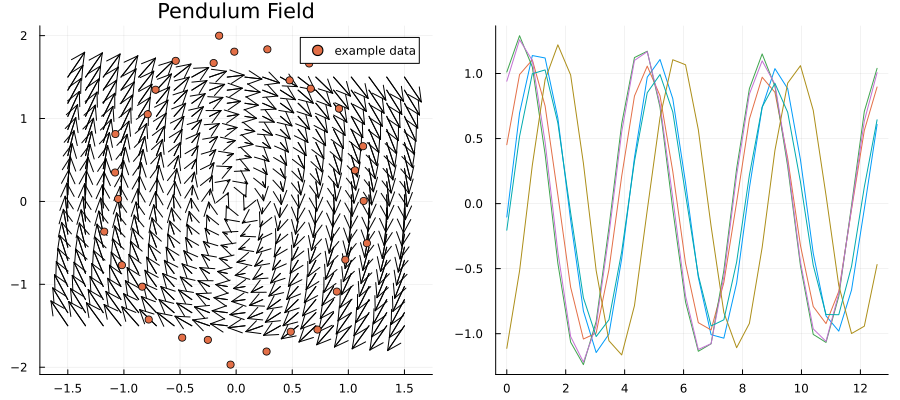

In [78]:
#We showcase the training data
quiver(fieldd[1, :],fieldd[2, :],quiver=(spring_field[1, :], spring_field[2, :]), layout=(1,2),size=(900,400), title="Pendulum Field", label="train data",c=:black)
for i in 2:7 #A random selection of simulations
    plot!(t, x_train[1,:,i], subplot=2,legend=false)
end
scatter!(x_train[1,:,1], x_train[2,:,1], label="example data",subplot=1)

<h2 style="font-family:Times New Roman; font-size:200%">Conducting analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    We will now train the HNN's with tanh, sigmoid, mish, swish and gelu, each with various gains=0.01,0.1,0.5,1,s^0.5,2 and 5. This is done for Kaiming, Glorot and Orthogonal weight initilization. The example presented here consists of 64 neurons, with one hidden layer. All models are trained with ADAM, learning rate of 0.001, 1000 epochs and random seed 2024.
</p>


In [83]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.01, .1, .5, 1, 2^0.5, 2, 5]

MSE_valsk = zeros(length(activations), length(gains)) 
MSE_valsg = zeros(length(activations), length(gains))
MSE_valso = zeros(length(activations), length(gains))

for (a_idx, act) in enumerate(activations)
    for (g_idx, g_val) in enumerate(gains)
        
        _, LuxH_k = models(2, 64, act, Kaiming(g_val),1)
        _, LuxH_g = models(2, 64, act, Glorot(g_val),1)
        _, LuxH_o = models(2, 64, act, Orthogonal(g_val),1)

        
        println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk[a_idx,g_idx] = lossk

        println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1000)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg[a_idx,g_idx] = lossg
        
        println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=1000)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso[a_idx,g_idx] = losso
    end
end

 -----  Training Kaiming  ----- 
Epoch=200 :loss = 0.18640971
Epoch=400 :loss = 0.18597753
Epoch=600 :loss = 0.18594928
Epoch=800 :loss = 0.1859488
Epoch=1000 :loss = 0.18594827
 -----  Training Glorot  ----- 
Epoch=200 :loss = 0.1864651
Epoch=400 :loss = 0.18605563
Epoch=600 :loss = 0.18594666
Epoch=800 :loss = 0.18594788
Epoch=1000 :loss = 0.18594784
Epoch=1200 :loss = 0.18594779
Epoch=1400 :loss = 0.18594772
Epoch=1600 :loss = 0.18594764
Epoch=1800 :loss = 0.18594763
Epoch=2000 :loss = 0.18594752
 -----  Training Orthogonal  ----- 
Epoch=200 :loss = 0.1864652
Epoch=400 :loss = 0.18605852
Epoch=600 :loss = 0.18594645
Epoch=800 :loss = 0.18594784
Epoch=1000 :loss = 0.1859478
Epoch=1200 :loss = 0.18594779
Epoch=1400 :loss = 0.18594775
Epoch=1600 :loss = 0.1859477
Epoch=1800 :loss = 0.18594767
Epoch=2000 :loss = 0.18594767
 -----  Training Kaiming  ----- 
Epoch=200 :loss = 0.16642727
Epoch=400 :loss = 0.16579238
Epoch=600 :loss = 0.16508621
Epoch=800 :loss = 0.16441149
Epoch=1000 :loss 

LoadError: InterruptException:

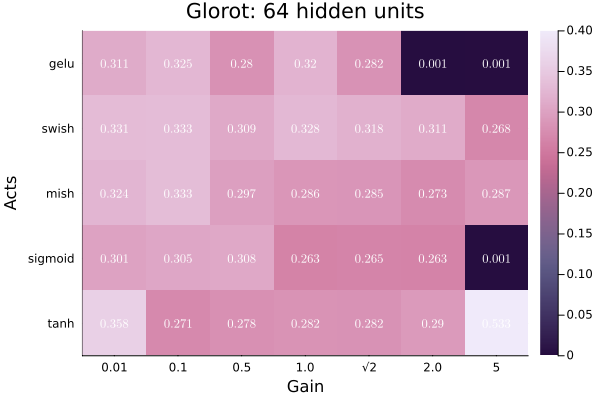

In [58]:
activations_str = ["tanh", "sigmoid", "mish", "swish", "gelu"]
[.01, .1, .5, 1, 2^0.5, 2, 5]
gain_str = ["0.01", "0.1", "0.5", "1.0", "√2", "2.0", "5"]
hg = heatmap(MSE_valsg, cmap=:acton,clim=(0, 0.4),title="Glorot: 64 hidden units", yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str), ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_valsg[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:length(activations) for j in 1:length(gains)])
hg

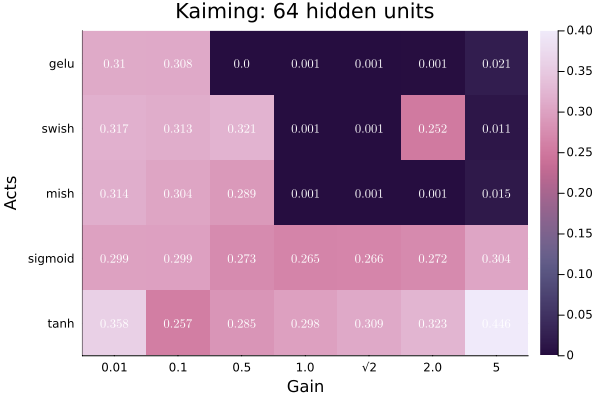

In [59]:
hk = heatmap(MSE_valsk, cmap=:acton, clim=(0,0.4),title="Kaiming: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk,[(j, i, text(round(MSE_valsk[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hk

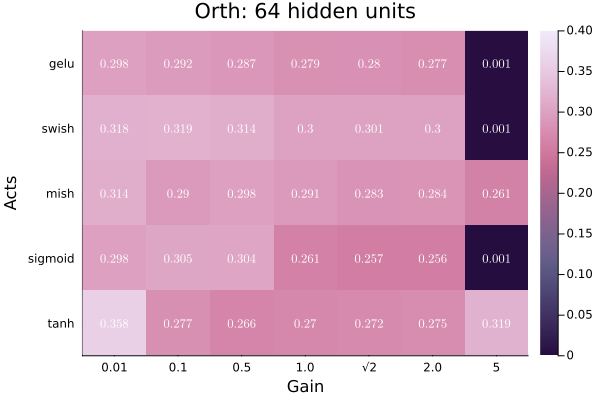

In [60]:
ho = heatmap(MSE_valso, cmap=:acton, clim=(0,0.4),title="Orth: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho,[(j, i, text(round(MSE_valso[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho

In [61]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.01, .1, .5, 1, 2^0.5, 2, 5]

MSE_valsk2 = zeros(length(activations), length(gains))
MSE_valsg2 = zeros(length(activations), length(gains))
MSE_valso2 = zeros(length(activations), length(gains))

for (a_idx, act) in enumerate(activations)
    for (g_idx, g_val) in enumerate(gains)
        
        _, LuxH_k = models(2, 64, act, Kaiming(g_val),2)
        _, LuxH_g = models(2, 64, act, Glorot(g_val),2)
        _, LuxH_o = models(2, 64, act, Orthogonal(g_val),2)

        
        println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000,lr=0.001,rng_nr=4001)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk2[a_idx,g_idx] = lossk

        println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=2000,rng_nr=4001)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg2[a_idx,g_idx] = lossg
        
        println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=2000,rng_nr=4001)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso2[a_idx,g_idx] = losso

    end
end

 -----  Training Kaiming  ----- 
Epoch=200 :loss = 0.35898352
Epoch=400 :loss = 0.3583878
Epoch=600 :loss = 0.3583848
Epoch=800 :loss = 0.358385
Epoch=1000 :loss = 0.3583851
 -----  Training Glorot  ----- 
Epoch=200 :loss = 0.3590296
Epoch=400 :loss = 0.35844818
Epoch=600 :loss = 0.35838592
Epoch=800 :loss = 0.35838577
Epoch=1000 :loss = 0.35838562
Epoch=1200 :loss = 0.35838556
Epoch=1400 :loss = 0.35838547
Epoch=1600 :loss = 0.35838538
Epoch=1800 :loss = 0.35838503
Epoch=2000 :loss = 0.35838515
 -----  Training Orthogonal  ----- 
Epoch=200 :loss = 0.35904828
Epoch=400 :loss = 0.35847655
Epoch=600 :loss = 0.35838616
Epoch=800 :loss = 0.35838604
Epoch=1000 :loss = 0.35838592
Epoch=1200 :loss = 0.35838586
Epoch=1400 :loss = 0.3583857
Epoch=1600 :loss = 0.35838556
Epoch=1800 :loss = 0.35838556
Epoch=2000 :loss = 0.35838526
 -----  Training Kaiming  ----- 
Epoch=200 :loss = 0.30912146
Epoch=400 :loss = 0.3067575
Epoch=600 :loss = 0.3057543
Epoch=800 :loss = 0.27258316
Epoch=1000 :loss = 0.

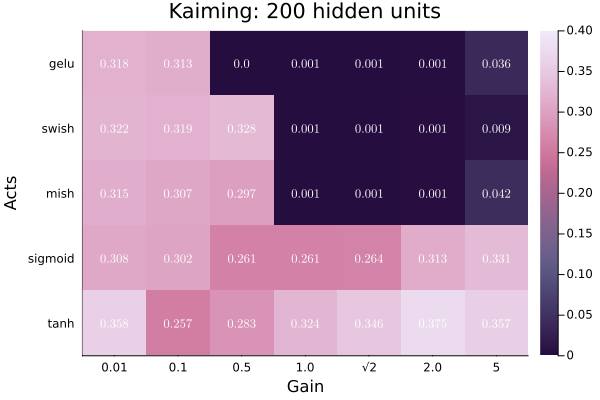

In [62]:
hk2 = heatmap(MSE_valsk2, cmap=:acton, clim=(0,0.4),title="Kaiming: 200 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk2,[(j, i, text(round(MSE_valsk2[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:length(activations) for j in 1:length(gains)])
hk2

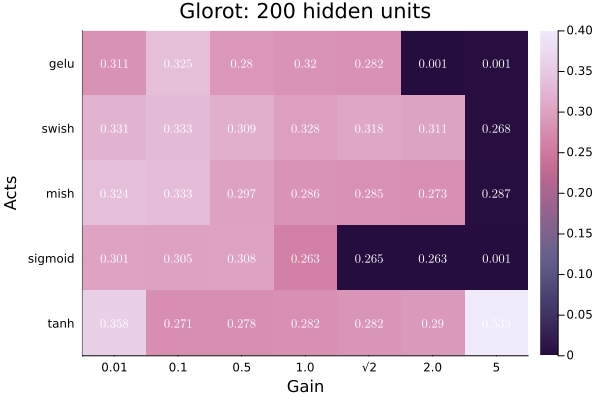

In [63]:
hg2 = heatmap(MSE_valsg2, cmap=:acton,clim=(0, 0.4),title="Glorot: 200 hidden units", yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str), ylabel="Acts",xlabel="Gain")
annotate!(hg2,[(j, i, text(round(MSE_valsg2[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:length(activations) for j in 1:length(gains)])
hg2

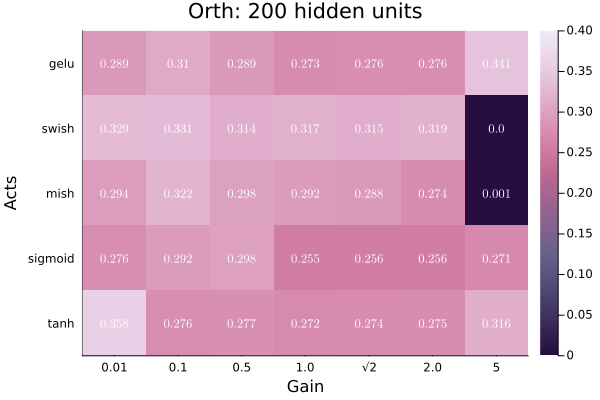

In [64]:
ho2 = heatmap(MSE_valso2, cmap=:acton, clim=(0,0.4),title="Orth: 200 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho2,[(j, i, text(round(MSE_valso2[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho2

<h2 style="font-family:Times New Roman; font-size:200%">Analysing Energy Heatmaps</h2>

<p style="font-family:Times New Roman; font-size:120%">
    As discussed in the project paper, the random seed has an abnormally large effect on the performance on each model. This is very strange, the data presented here motivates the pre-training scheme to be defined later.
</p>


In [66]:
function forward_with_logging(x, ps, st, model)
    # Iterate through each layer in the model
    layer_outputs = Dict{Symbol, Any}()
    for (i, layer) in enumerate(model.layers)
        x, st = layer(x, ps[i], st)  # Forward pass through the layer
        layer_outputs[Symbol("layer $i")] = x  # Log the output
    end
    return x, st,layer_outputs   # Return final output and state
end
# Create an empty array to store each layer's plot
function layersplot(hidden,act, g=2^0.5, num_layers=2)
    
    _, LuxH_k = models(2, hidden, act, Kaiming(g),num_layers) #Fetch models
    _, LuxH_g = models(2, hidden, act, Glorot(g),num_layers)
    pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001)
    pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001) #Train models
    #pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001)

    _, _, layer_outputs_k = forward_with_logging(x_test, pHNN_k, sHNN_k, LuxH_k) #Find outputs
    _, _,layer_outputs_g = forward_with_logging(x_test, pHNN_g, sHNN_g, LuxH_g)
    
    plots = []
    limit=200 #limit to amount of Batches to plot
    neurons = 80 #Limit for how many neurons to display

    # Generate a plot for each layer output and add it to the array
    for (layer_name, output_k) in layer_outputs_k
        output_g = layer_outputs_g[layer_name]
        if size(output_k)[1]!=1
            lim  = min(size(output_k)[2], limit)
            neur_nr  = min(size(output_k)[1], neurons)
            
            ymin = min(minimum(output_k[1:neur_nr, 1:lim]), minimum(output_g[1:neur_nr, 1:lim]))
            ymax = max(maximum(output_k[1:neur_nr, 1:lim]), maximum(output_g[1:neur_nr, 1:lim]))
            
            # Plot Kaiming and Glorot side by side
            pk = plot(output_k[1:neur_nr, 1:lim], ylims=(ymin, ymax),
                title=string(layer_name, " (Kaiming)"), xlabel="Neuron", ylabel="Output", legend=false)
            pg = plot(output_g[1:neur_nr, 1:lim], ylims=(ymin, ymax),
                title=string(layer_name, " (Glorot)"), xlabel="Neuron", ylabel="Output", legend=false)
        else
            lim = min(length(output_k), limit)
            
            # Find global y-axis limits for this layer
            ymin = min(minimum(output_k[1:lim]), minimum(output_g[1:lim]))
            ymax = max(maximum(output_k[1:lim]), maximum(output_g[1:lim]))
            
            pk = plot(output_k[1:lim], ylims=(ymin, ymax),
                title="Convergent Output", xlabel="input #", ylabel="Output", legend=false)
            pg = plot(output_g[1:lim], ylims=(ymin, ymax),
                title="Non-Convergent Output", xlabel="input #", ylabel="Output", legend=false)
        end
        
        # Arrange side-by-side
        push!(plots, plot(pk, pg, layout=(1, 2)))#, size=(1000, 400)))
    end
    
    #return plo
    # Display all plots in a grid layout
    plot(plots..., layout = (length(layer_outputs_k), 1),legend=false, size=(1000, 1000))  # Arrange in a vertical grid
end

layersplot (generic function with 3 methods)

Epoch=200 :loss = 0.4626783
Epoch=400 :loss = 0.44972998
Epoch=600 :loss = 0.44206867
Epoch=800 :loss = 0.43051654
Epoch=1000 :loss = 0.4112006
Epoch=200 :loss = 0.0011990225
Epoch=400 :loss = 0.0009057309
Epoch=600 :loss = 0.0008094629
Epoch=800 :loss = 0.0007851365
Epoch=1000 :loss = 0.0007629017


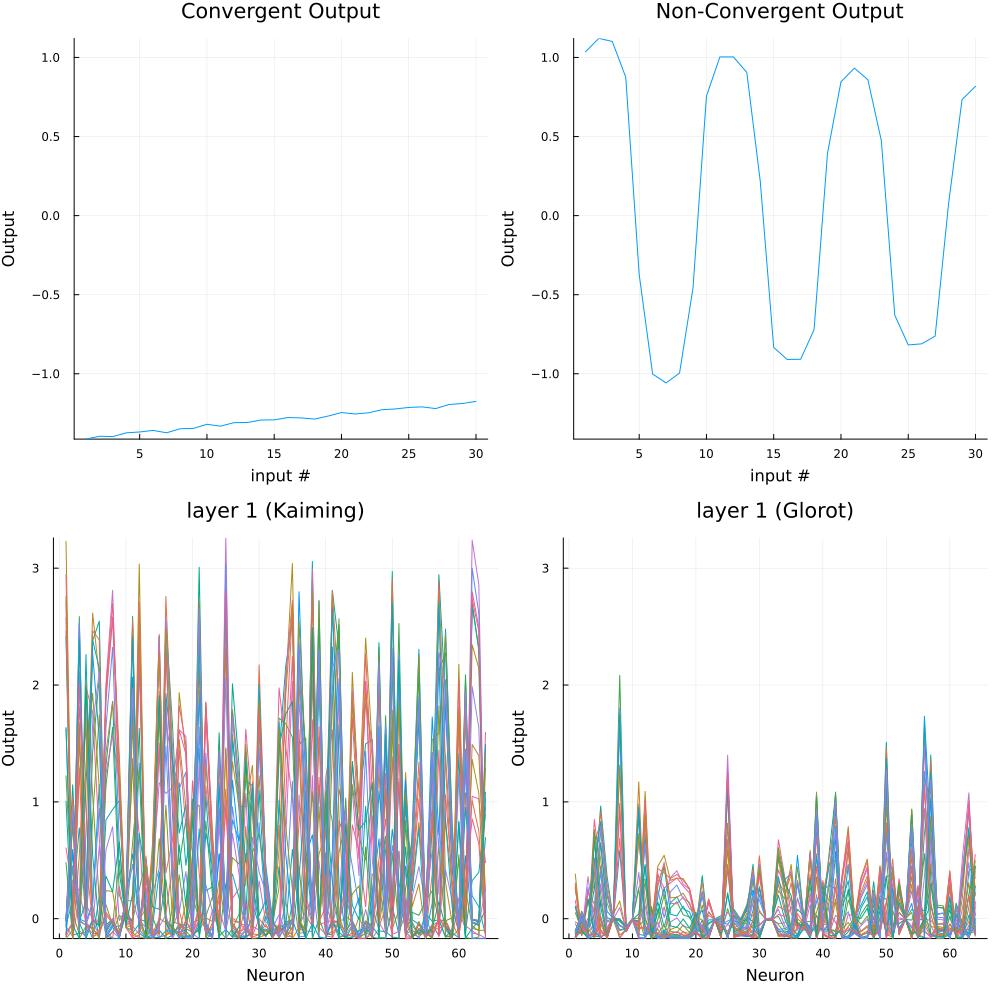

In [67]:
layersplot(64, gelu, 2^0.5,1) #This is interesting to compare since kaiming diverges and glorot converges

In [33]:
function gradientsplot(model, x, ps, st, y)
    plots = []
    limit=200
    neurons = 80
    # Generate a plot for each layer output and add it to the array
    _, _, ∂ps,_,_ = Zygote.gradient(lossHNN, model, x, ps, st,y)
    i=1
    for (weight) in ∂ps
        if length(weight)==2
            weights, biases= weight
            p = plot(weights, title="Layer $i", xlabel="Weight/bias", ylabel="Grad.",legend=false)
            p = plot!(biases, color=:black,legend=false)
        else
            weights = weight[1][1,:]
            p = plot(weights, title="Layer $i", xlabel="Weights", ylabel="Grad.",lagend=false)
        end
        push!(plots, p)
        i+=1
    end

    # Display all plots in a grid layout
    plot(plots..., layout = (length(plots), 1),legend=false)  # Arrange in a vertical grid
end

gradientsplot (generic function with 1 method)

In [169]:
function gradientsplot_compare(hidden,act, g=2^0.5, num_layers=2)
    
    _, LuxH_k = models(2, hidden, act, Kaiming(g),num_layers) #Fetch models
    _, LuxH_g = models(2, hidden, act, Glorot(g),num_layers)
    
    pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000) #Train models
    pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1000)
    println(lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test))
    println(lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test))
    plots = []
    limit = 200  # Limit for number of batches (if needed)
    neurons = 80  # Limit for neurons (if needed)

    # Compute gradients for both models
    _, _, ∂ps_k, _, _ = Zygote.gradient(lossHNN, LuxH_k, x_test, pHNN_k, sHNN_k, y_test)
    _, _, ∂ps_g, _, _ = Zygote.gradient(lossHNN, LuxH_g, x_test, pHNN_g, sHNN_g, y_test)

    # Iterate through gradients for each layer
    i = 1
    for (grad_k, grad_g) in zip(∂ps_k, ∂ps_g)
        if i!=num_layers+1
            if length(grad_k) == 2  # Layer has weights and biases
                weights_k, biases_k = grad_k
                weights_g, biases_g = grad_g
                # Determine y-axis limits across both models
                ymin = min(minimum(weights_k), minimum(biases_k), minimum(weights_g), minimum(biases_g))
                ymax = max(maximum(weights_k), maximum(biases_k), maximum(weights_g), maximum(biases_g))

                # Plot Kaiming gradients
                pk = plot(weights_k, ylims=(ymin, ymax), title="Layer $i (Kaiming)", xlabel="Weight/Bias", ylabel="Gradient", legend=false)
                plot!(pk, biases_k, color=:black, legend=false)

                # Plot Glorot gradients
                pg = plot(weights_g, ylims=(ymin, ymax), title="Layer $i (Glorot)", xlabel="Weight/Bias", ylabel="Gradient", legend=false)
                plot!(pg, biases_g, color=:black, legend=false)
                i += 1
                push!(plots, plot(pk, pg, layout=(1, 2)))
            end
            # Arrange Kaiming and Glorot side by side
        end
        
    end
    println(length(plots))
    # Display all plots in a 3x2 grid layout
    return plot(plots..., layout=(num_layers, 1), size=(1000, 1000), legend=false)
end

gradientsplot_compare (generic function with 3 methods)

0.6015241
0.00050257274
2


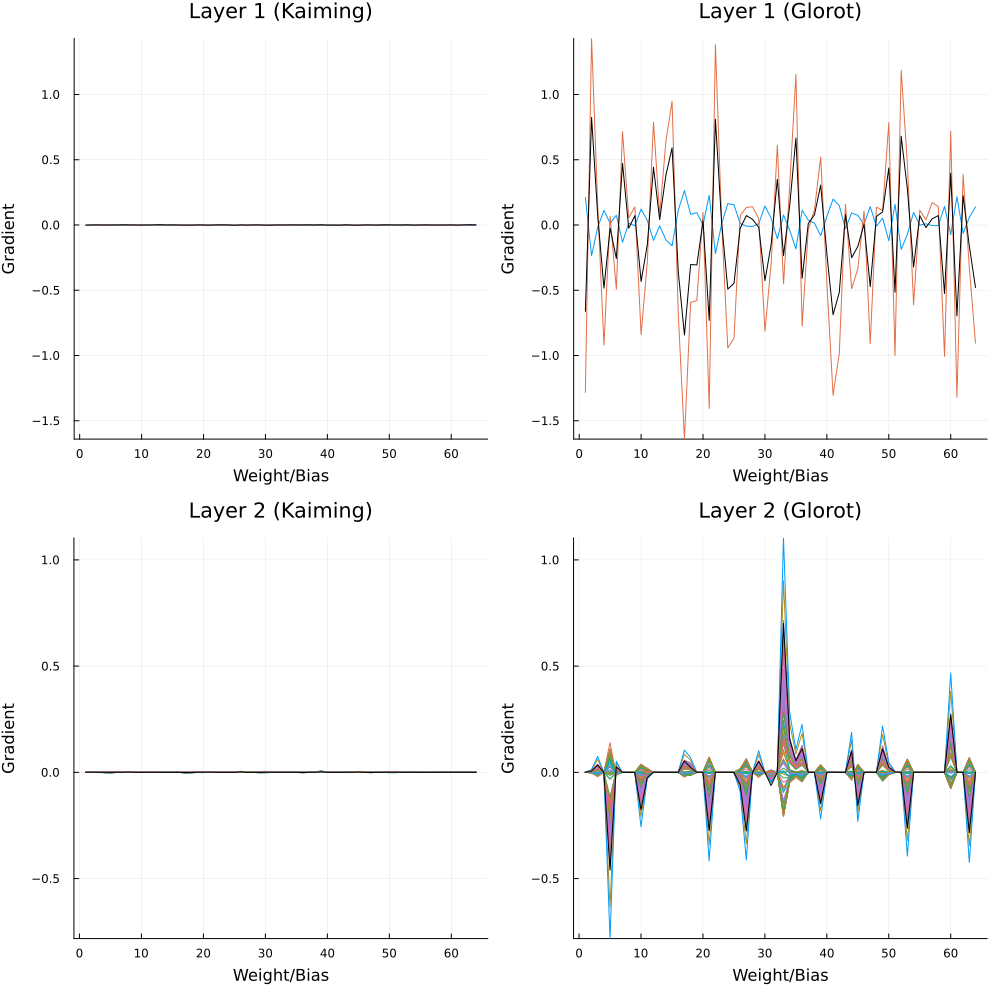

In [172]:
gradientsplot_compare(64, swish, 1,2)

0.56622124
0.6749211
2


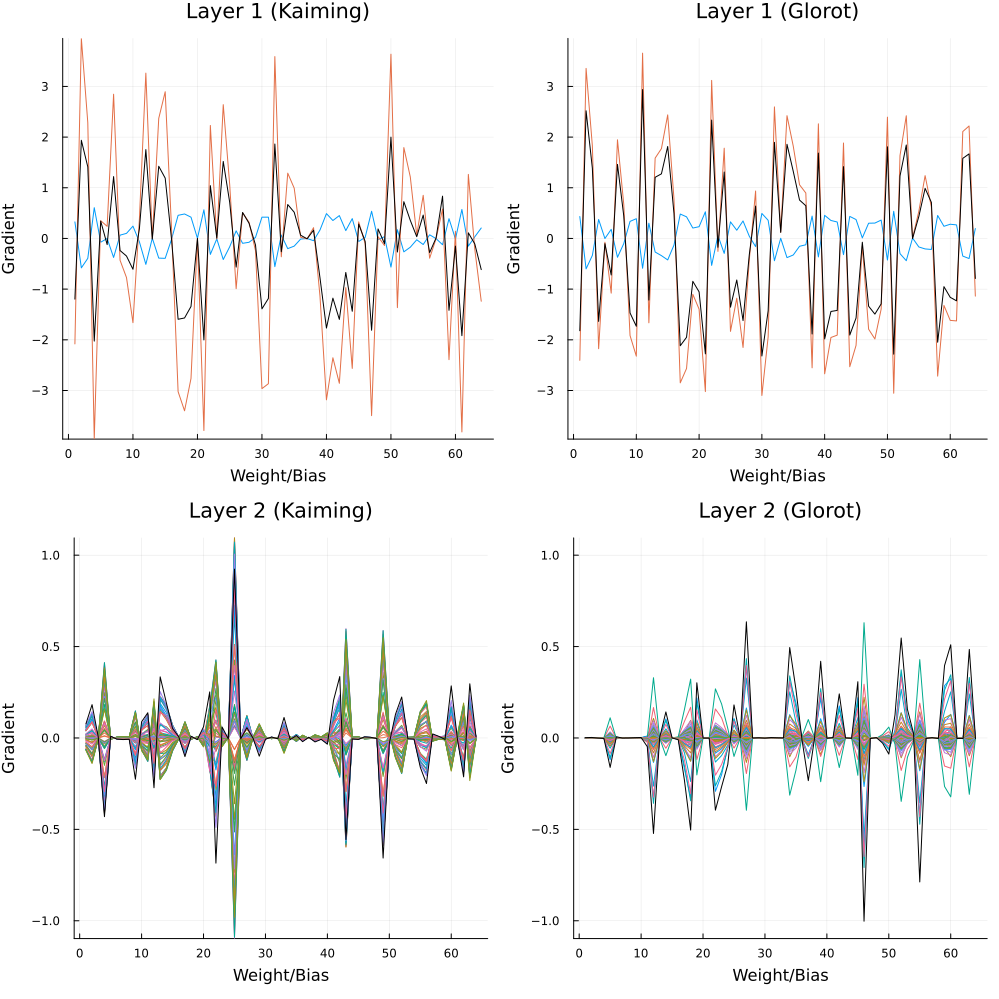

In [170]:
gradientsplot_compare(64, tanh, 1,2)

0.41389212
0.37472624
2


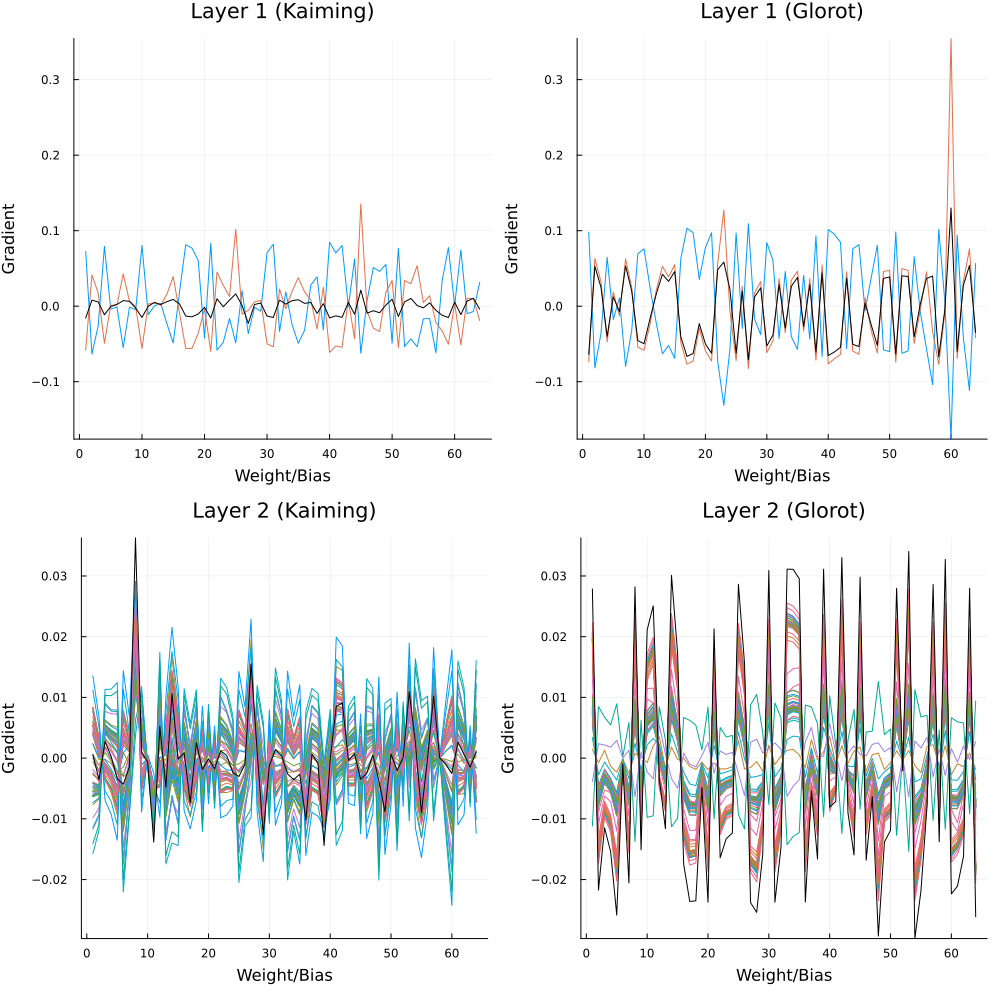

In [171]:
gradientsplot_compare(64, sigmoid, 1,2)